In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np

In [4]:
from librep.datasets.har.loaders import MotionSense_BalancedView20HZ

2022-10-25 10:43:19.935140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 10:43:19.935160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport
from Experiments_topoae_KuHar20Hz_helper import *

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()
# kuhar_data = obtainKuHar20Hz()
# train_HD = kuhar_data['train_HD']
# train_LD = kuhar_data['train_LD']
# train_Y = kuhar_data['train_Y']
# test_HD = kuhar_data['test_HD']
# test_LD = kuhar_data['test_LD']
# test_Y = kuhar_data['test_Y']

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

# Visualization helper

In [9]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [11]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [12]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [13]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [14]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Exploring Topological AE (dimensions)

In [15]:
dimensions_to_explore = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
dimensions_to_explore = [2, 5, 10, 100]
executions_per_model = 10
executions_per_model = 2

def explore_dimension(train_HD, train_Y, test_HD, test_Y, topoae_dimension, times_to_execute=10):
    topoae_lambda = 1000
    result_object = {
        'RF-ACC': [],
        'RF-F1': [],
        'SVC-ACC': [],
        'SVC-F1': [],
        'KNN-ACC': [],
        'KNN-F1': [],
        'Trustworthiness': [],
        'Continuity': [],
        'Co-k-NNs': []   
    }
    for _ in range(times_to_execute):
        kwargs = {'input_dims':360, 'custom_dim':topoae_dimension}
        input_shape = (-1, 1, 360)
        topo_reducer = TopologicalDimensionalityReduction(
            ae_model='DeepAEforKuhar180ver2',
            lam=topoae_lambda,
            ae_kwargs=kwargs,
            input_shape=input_shape,
            patience=10
        )
        title_plot = "MotionSense 20Hz\nTopoAE lambda " + str(topoae_lambda)
        topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)
        train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, topoae_dimension))
        test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, topoae_dimension))
        experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
        metrics_reporter = DimensionalityReductionQualityReport()
        metrics_report = metrics_reporter.evaluate([test_HD, test_LD])
        
        result_object['RF-ACC'].append(experiments_result['RF-ACC'])
        result_object['RF-F1'].append(experiments_result['RF-F1'])
        result_object['SVC-ACC'].append(experiments_result['SVC-ACC'])
        result_object['SVC-F1'].append(experiments_result['SVC-F1'])
        result_object['KNN-ACC'].append(experiments_result['KNN-ACC'])
        result_object['KNN-F1'].append(experiments_result['KNN-F1'])
        
        result_object['Trustworthiness'].append(metrics_report['trustworthiness'])
        result_object['Continuity'].append(metrics_report['continuity'])
        result_object['Co-k-NNs'].append(metrics_report['co k nearest neighbor size'])
        
    # for obj_property in result_object:
    #     mean_val = np.mean(result_object[obj_property])
    #     min_val = np.min(result_object[obj_property])
    #     max_val = np.max(result_object[obj_property])
    #     result_object[obj_property] = (min_val, mean_val, max_val)

    return result_object


Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 2
Epoch:1, P:10, Loss:27.1790, Loss-ae:18.2576, Loss-topo:0.0089
Epoch:2, P:10, Loss:21.4161, Loss-ae:17.1832, Loss-topo:0.0042
Epoch:3, P:10, Loss:21.3782, Loss-ae:16.3290, Loss-topo:0.0050
Epoch:4, P:10, Loss:24.1290, Loss-ae:16.2675, Loss-topo:0.0079
Epoch:5, P:9, Loss:19.7015, Loss-ae:15.3531, Loss-topo:0.0043
Epoch:6, P:10, Loss:20.2618, Loss-ae:14.8526, Loss-topo:0.0054
Epoch:7, P:9, Loss:22.1318, Loss-ae:14.3595, Loss-topo:0.0078
Epoch:8, P:8, Loss:24.8563, Loss-ae:14.4123, Loss-topo:0.0104
Epoch:9, P:7, Loss:19.7321, Loss-ae:14.8062, Loss-topo:0.0049
Epoch:10, P:6, Loss:19.2517, Loss-ae:14.5799, Loss-topo:0.0047
Epoch:11, P:10, Loss:19.1757, Loss-ae:14.1553, Loss-topo:0.0050
Epoch:12, P:10, Loss:23.7154, Loss-ae:14.7780, Loss-topo:0.0089
Epoch:13, P:9, Loss:17.7901, Loss-ae:14.7830, Loss-topo:0.0030
Epoch:14, P:10, Loss:16.5445, Loss-ae:14.1188, Loss-t

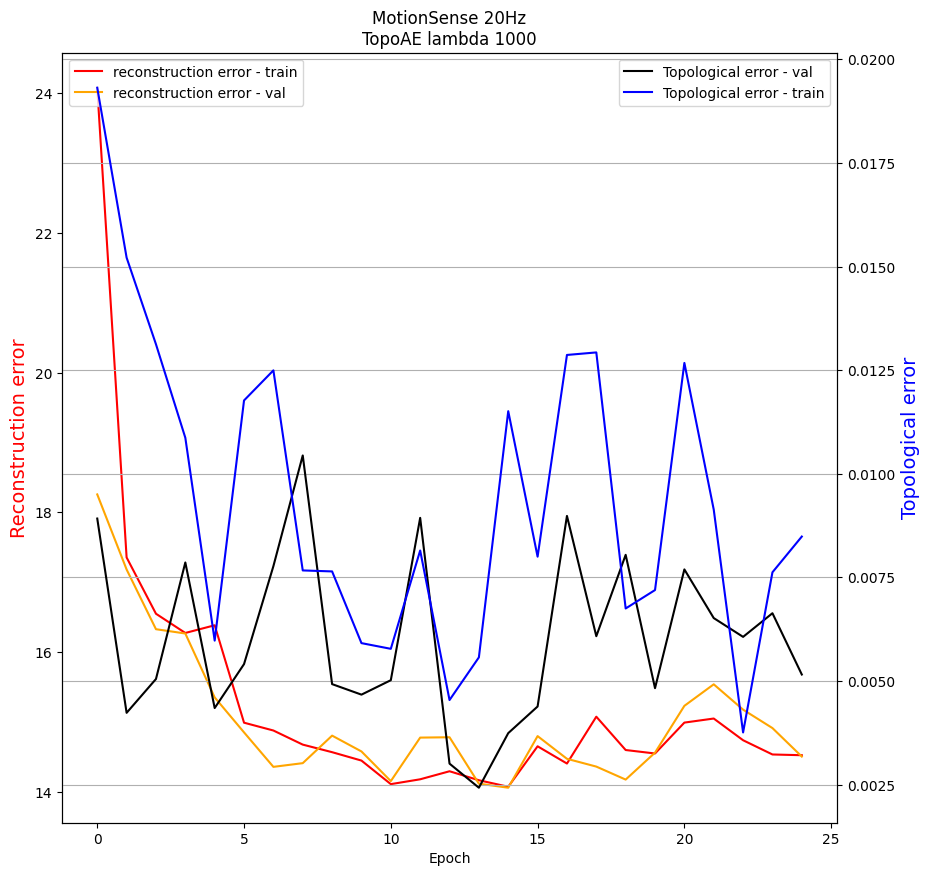

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 2
Epoch:1, P:10, Loss:25.8190, Loss-ae:20.1734, Loss-topo:0.0056
Epoch:2, P:10, Loss:24.2320, Loss-ae:18.5518, Loss-topo:0.0057
Epoch:3, P:10, Loss:22.4769, Loss-ae:16.8798, Loss-topo:0.0056
Epoch:4, P:10, Loss:24.0554, Loss-ae:16.6557, Loss-topo:0.0074
Epoch:5, P:9, Loss:23.9505, Loss-ae:17.5510, Loss-topo:0.0064
Epoch:6, P:8, Loss:23.7999, Loss-ae:16.3962, Loss-topo:0.0074
Epoch:7, P:7, Loss:23.0320, Loss-ae:15.1111, Loss-topo:0.0079
Epoch:8, P:6, Loss:19.8373, Loss-ae:15.0801, Loss-topo:0.0048
Epoch:9, P:10, Loss:32.0402, Loss-ae:16.3037, Loss-topo:0.0157
Epoch:10, P:9, Loss:22.7426, Loss-ae:15.8929, Loss-topo:0.0068
Epoch:11, P:8, Loss:20.2801, Loss-ae:14.7525, Loss-topo:0.0055
Epoch:12, P:7, Loss:18.0985, Loss-ae:14.8615, Loss-topo:0.0032
Epoch:13, P:10, Loss:20.9097, Loss-ae:15.6203, Loss-topo:0.0053
Epoch:14, P:9, Loss:22.3340, Loss-ae:14.9735, Loss-top

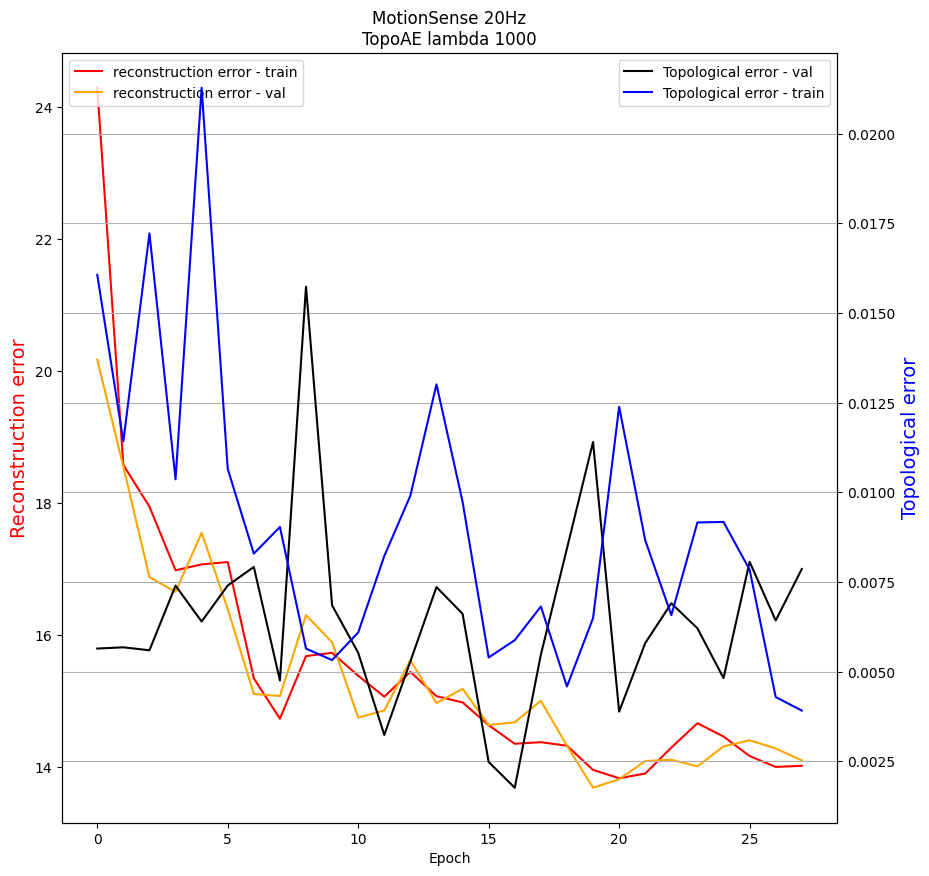

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 5
Epoch:1, P:10, Loss:24.7521, Loss-ae:22.0366, Loss-topo:0.0027
Epoch:2, P:10, Loss:24.6004, Loss-ae:20.1644, Loss-topo:0.0044
Epoch:3, P:10, Loss:21.5360, Loss-ae:19.7074, Loss-topo:0.0018
Epoch:4, P:10, Loss:20.4978, Loss-ae:19.0301, Loss-topo:0.0015
Epoch:5, P:10, Loss:23.6685, Loss-ae:19.3830, Loss-topo:0.0043
Epoch:6, P:9, Loss:18.8967, Loss-ae:17.5510, Loss-topo:0.0013
Epoch:7, P:10, Loss:17.9495, Loss-ae:16.7789, Loss-topo:0.0012
Epoch:8, P:10, Loss:18.3480, Loss-ae:16.6508, Loss-topo:0.0017
Epoch:9, P:9, Loss:17.3449, Loss-ae:15.8703, Loss-topo:0.0015
Epoch:10, P:10, Loss:16.6566, Loss-ae:15.4517, Loss-topo:0.0012
Epoch:11, P:10, Loss:17.3800, Loss-ae:15.5393, Loss-topo:0.0018
Epoch:12, P:9, Loss:17.2284, Loss-ae:15.9834, Loss-topo:0.0012
Epoch:13, P:8, Loss:16.8873, Loss-ae:15.6391, Loss-topo:0.0012
Epoch:14, P:7, Loss:17.6540, Loss-ae:15.3310, Loss-

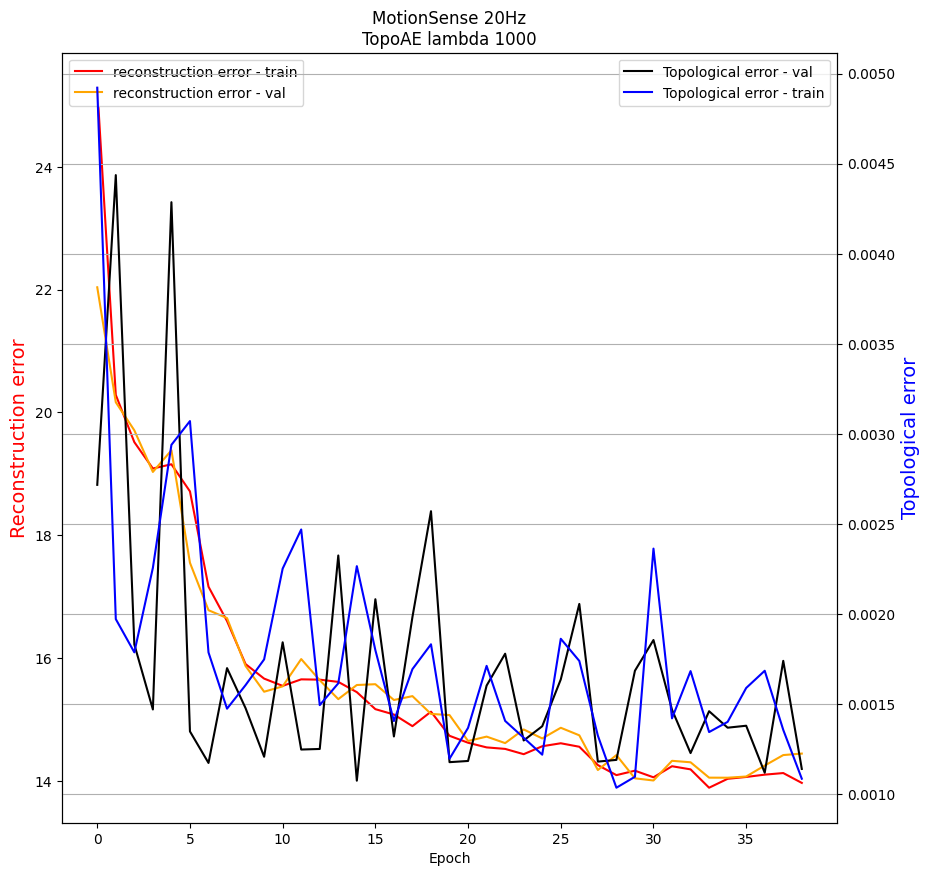

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 5
Epoch:1, P:10, Loss:26.1017, Loss-ae:24.0767, Loss-topo:0.0020
Epoch:2, P:10, Loss:20.5943, Loss-ae:18.7445, Loss-topo:0.0018
Epoch:3, P:10, Loss:21.0663, Loss-ae:18.8892, Loss-topo:0.0022
Epoch:4, P:9, Loss:20.3560, Loss-ae:18.6315, Loss-topo:0.0017
Epoch:5, P:10, Loss:19.9096, Loss-ae:18.0961, Loss-topo:0.0018
Epoch:6, P:10, Loss:18.4391, Loss-ae:16.6496, Loss-topo:0.0018
Epoch:7, P:10, Loss:18.7927, Loss-ae:15.9067, Loss-topo:0.0029
Epoch:8, P:9, Loss:17.7188, Loss-ae:15.4800, Loss-topo:0.0022
Epoch:9, P:10, Loss:17.5040, Loss-ae:15.4203, Loss-topo:0.0021
Epoch:10, P:10, Loss:17.6904, Loss-ae:15.6786, Loss-topo:0.0020
Epoch:11, P:9, Loss:16.7897, Loss-ae:15.6412, Loss-topo:0.0011
Epoch:12, P:10, Loss:17.1014, Loss-ae:15.5074, Loss-topo:0.0016
Epoch:13, P:9, Loss:16.8264, Loss-ae:15.5161, Loss-topo:0.0013
Epoch:14, P:8, Loss:16.5068, Loss-ae:15.2702, Loss-

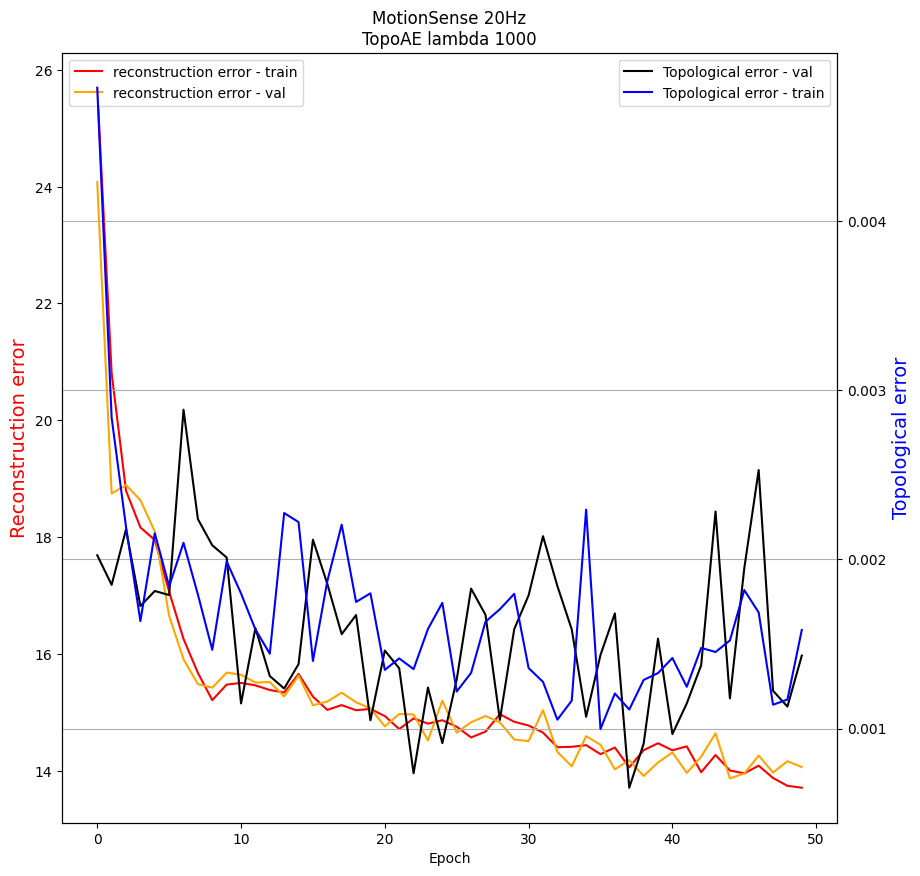

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 10
Epoch:1, P:10, Loss:25.5958, Loss-ae:23.5513, Loss-topo:0.0020
Epoch:2, P:10, Loss:18.8237, Loss-ae:17.8435, Loss-topo:0.0010
Epoch:3, P:10, Loss:18.3445, Loss-ae:17.1215, Loss-topo:0.0012
Epoch:4, P:10, Loss:18.1353, Loss-ae:16.8846, Loss-topo:0.0013
Epoch:5, P:10, Loss:18.0854, Loss-ae:16.4474, Loss-topo:0.0016
Epoch:6, P:10, Loss:17.7891, Loss-ae:16.4207, Loss-topo:0.0014
Epoch:7, P:10, Loss:17.3679, Loss-ae:15.8400, Loss-topo:0.0015
Epoch:8, P:10, Loss:16.5254, Loss-ae:15.2820, Loss-topo:0.0012
Epoch:9, P:10, Loss:16.8669, Loss-ae:15.7205, Loss-topo:0.0011
Epoch:10, P:9, Loss:16.8200, Loss-ae:15.5217, Loss-topo:0.0013
Epoch:11, P:8, Loss:16.0150, Loss-ae:14.9698, Loss-topo:0.0010
Epoch:12, P:10, Loss:15.6394, Loss-ae:14.8077, Loss-topo:0.0008
Epoch:13, P:10, Loss:16.1736, Loss-ae:14.5660, Loss-topo:0.0016
Epoch:14, P:9, Loss:16.2011, Loss-ae:14.8651, Lo

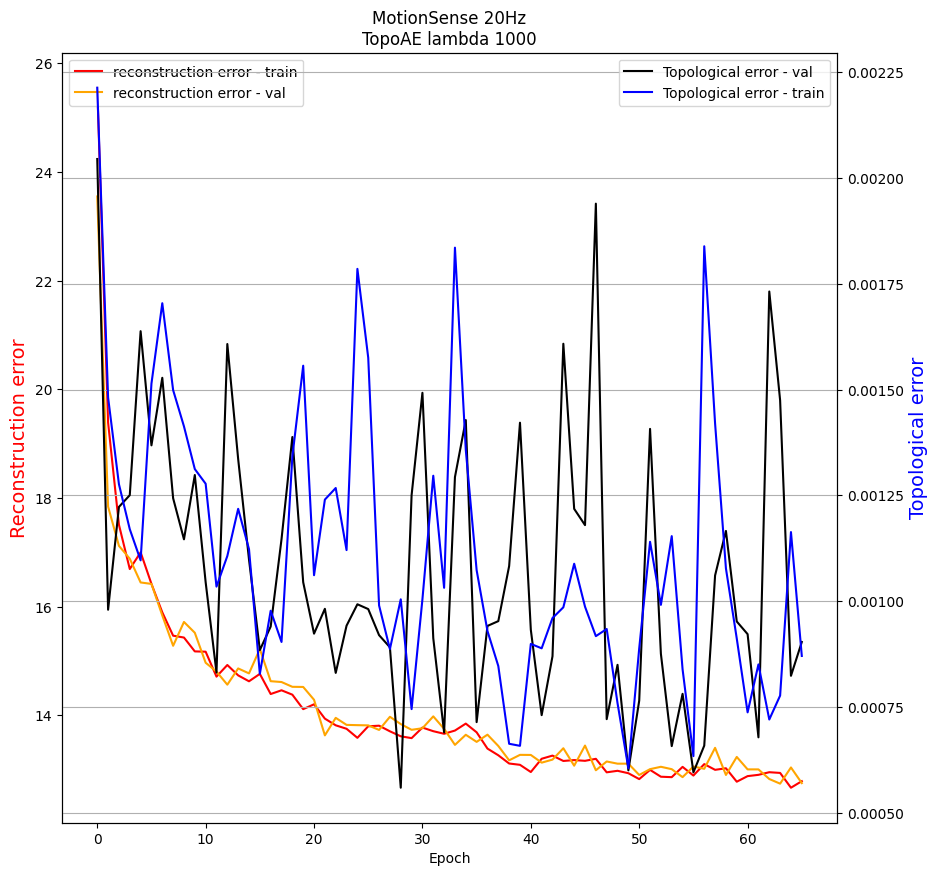

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 10
Epoch:1, P:10, Loss:26.5409, Loss-ae:23.7551, Loss-topo:0.0028
Epoch:2, P:10, Loss:19.8212, Loss-ae:18.1661, Loss-topo:0.0017
Epoch:3, P:10, Loss:18.6308, Loss-ae:17.1650, Loss-topo:0.0015
Epoch:4, P:10, Loss:18.0981, Loss-ae:17.1276, Loss-topo:0.0010
Epoch:5, P:10, Loss:16.8255, Loss-ae:15.8460, Loss-topo:0.0010
Epoch:6, P:10, Loss:17.7139, Loss-ae:16.4806, Loss-topo:0.0012
Epoch:7, P:9, Loss:17.9512, Loss-ae:15.7950, Loss-topo:0.0022
Epoch:8, P:8, Loss:15.5742, Loss-ae:14.6794, Loss-topo:0.0009
Epoch:9, P:10, Loss:16.1693, Loss-ae:15.0749, Loss-topo:0.0011
Epoch:10, P:9, Loss:15.8618, Loss-ae:15.0410, Loss-topo:0.0008
Epoch:11, P:8, Loss:16.0698, Loss-ae:15.0390, Loss-topo:0.0010
Epoch:12, P:7, Loss:17.2305, Loss-ae:15.0718, Loss-topo:0.0022
Epoch:13, P:6, Loss:16.1945, Loss-ae:14.6182, Loss-topo:0.0016
Epoch:14, P:5, Loss:16.7824, Loss-ae:15.0679, Loss-t

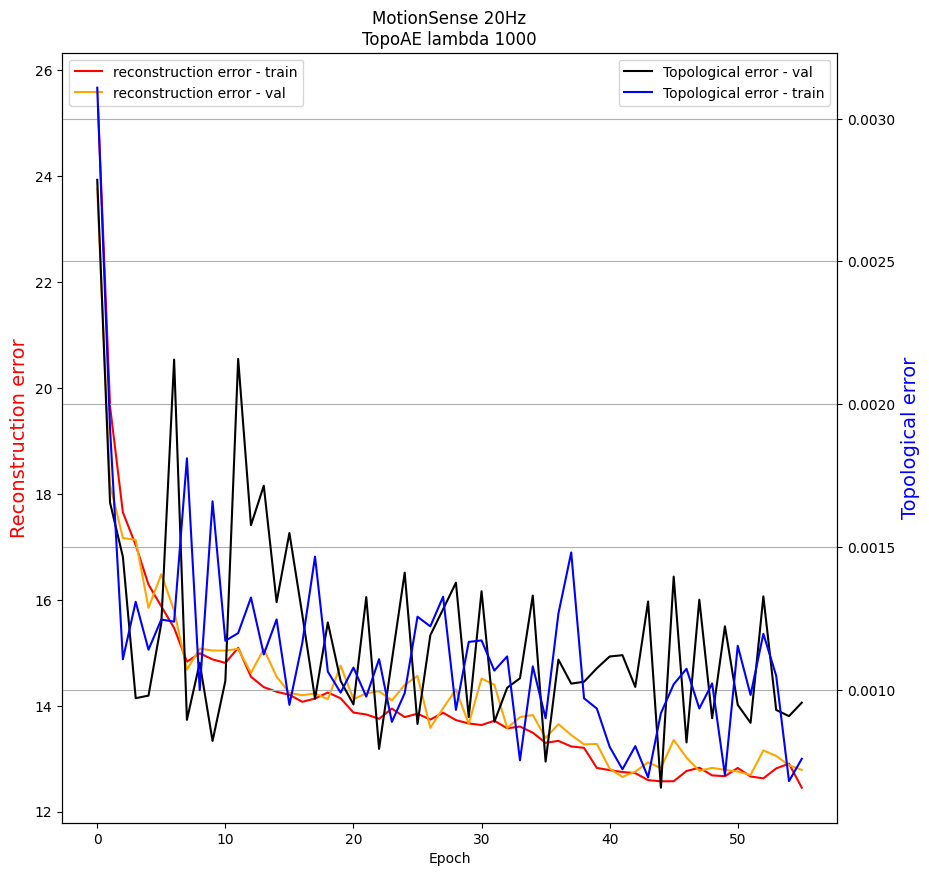

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 100
Epoch:1, P:10, Loss:23.5895, Loss-ae:22.3186, Loss-topo:0.0013
Epoch:2, P:10, Loss:20.1149, Loss-ae:18.2308, Loss-topo:0.0019
Epoch:3, P:10, Loss:19.1608, Loss-ae:17.9437, Loss-topo:0.0012
Epoch:4, P:10, Loss:17.7564, Loss-ae:16.5586, Loss-topo:0.0012
Epoch:5, P:10, Loss:17.4854, Loss-ae:15.8508, Loss-topo:0.0016
Epoch:6, P:10, Loss:17.1520, Loss-ae:15.7519, Loss-topo:0.0014
Epoch:7, P:10, Loss:15.6282, Loss-ae:14.9047, Loss-topo:0.0007
Epoch:8, P:10, Loss:16.8561, Loss-ae:15.2155, Loss-topo:0.0016
Epoch:9, P:9, Loss:15.4758, Loss-ae:14.4112, Loss-topo:0.0011
Epoch:10, P:10, Loss:15.7997, Loss-ae:14.7339, Loss-topo:0.0011
Epoch:11, P:9, Loss:16.5858, Loss-ae:14.6072, Loss-topo:0.0020
Epoch:12, P:8, Loss:17.4038, Loss-ae:15.0143, Loss-topo:0.0024
Epoch:13, P:7, Loss:15.1666, Loss-ae:13.9971, Loss-topo:0.0012
Epoch:14, P:10, Loss:14.7842, Loss-ae:13.7966, Lo

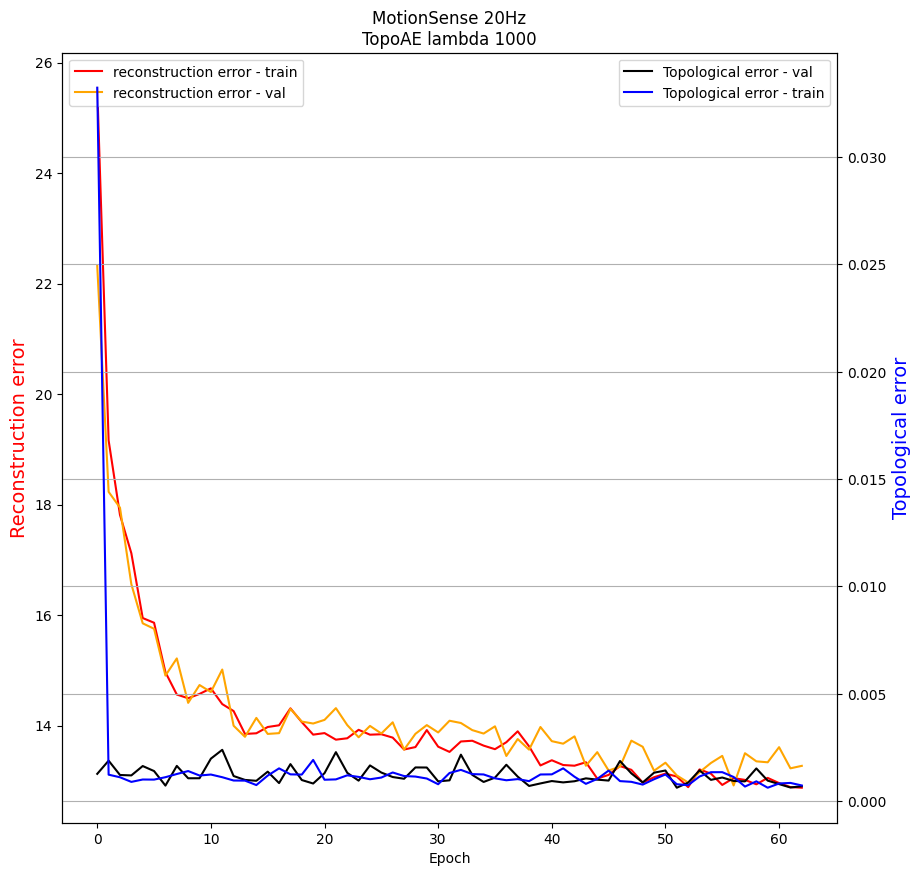

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 360 Inner dim: 100
Epoch:1, P:10, Loss:23.9777, Loss-ae:22.3982, Loss-topo:0.0016
Epoch:2, P:10, Loss:19.5908, Loss-ae:18.5431, Loss-topo:0.0010
Epoch:3, P:10, Loss:19.5484, Loss-ae:18.2826, Loss-topo:0.0013
Epoch:4, P:10, Loss:20.0830, Loss-ae:17.8506, Loss-topo:0.0022
Epoch:5, P:9, Loss:18.6956, Loss-ae:17.1273, Loss-topo:0.0016
Epoch:6, P:10, Loss:18.0310, Loss-ae:17.0638, Loss-topo:0.0010
Epoch:7, P:10, Loss:17.2712, Loss-ae:15.9850, Loss-topo:0.0013
Epoch:8, P:10, Loss:17.4214, Loss-ae:16.0926, Loss-topo:0.0013
Epoch:9, P:9, Loss:17.3696, Loss-ae:16.2447, Loss-topo:0.0011
Epoch:10, P:8, Loss:16.9096, Loss-ae:16.1137, Loss-topo:0.0008
Epoch:11, P:10, Loss:17.6782, Loss-ae:16.3211, Loss-topo:0.0014
Epoch:12, P:9, Loss:17.6440, Loss-ae:16.2257, Loss-topo:0.0014
Epoch:13, P:8, Loss:17.2553, Loss-ae:16.1429, Loss-topo:0.0011
Epoch:14, P:7, Loss:17.2477, Loss-ae:15.7501, Loss

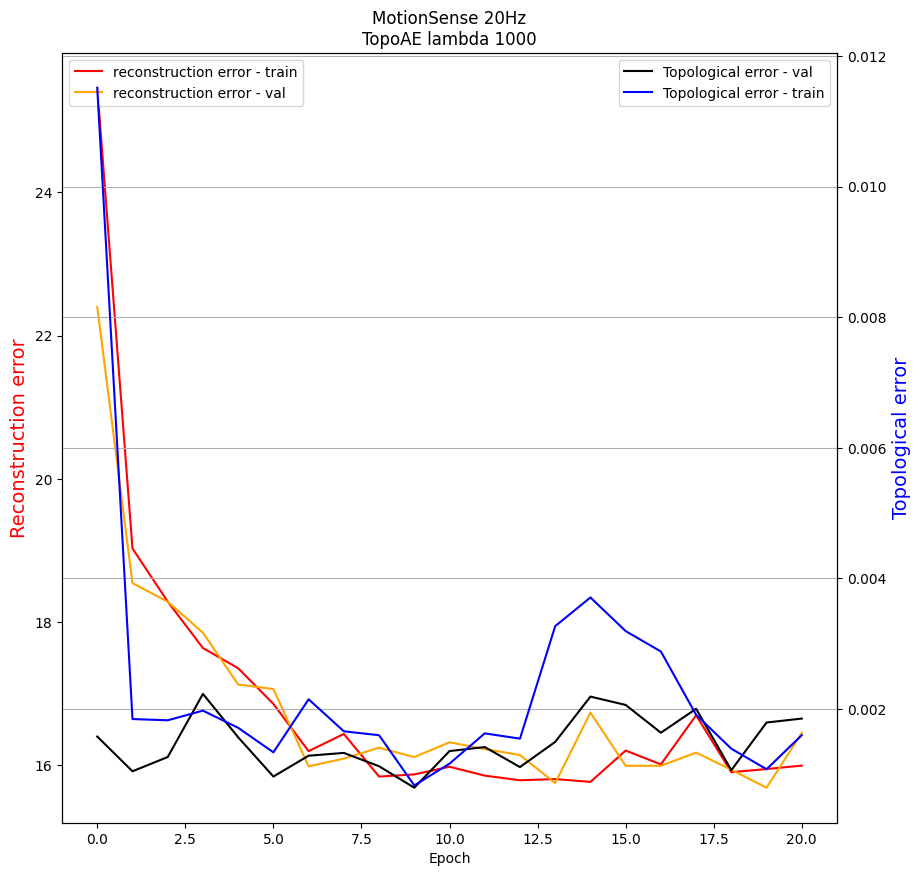

In [16]:
plot_object = {
    'RF-ACC': [],
    'RF-F1': [],
    'SVC-ACC': [],
    'SVC-F1': [],
    'KNN-ACC': [],
    'KNN-F1': [],
    'Trustworthiness': [],
    'Continuity': [],
    'Co-k-NNs': []   
}

for dimension in dimensions_to_explore:
    dimension_exploration = explore_dimension(
        train_HD, train_Y,
        test_HD, test_Y,
        dimension,
        times_to_execute=executions_per_model
    )
    # print(lambda_val, lambda_exploration)
    for obj_property in plot_object:
        plot_object[obj_property].append(dimension_exploration[obj_property])
    
# print(plot_object)

In [17]:
print(plot_object)

{'RF-ACC': [[0.27666666666666667, 0.3125490196078431], [0.5872549019607842, 0.5847058823529411], [0.6273529411764706, 0.6568627450980393], [0.6437254901960785, 0.616078431372549]], 'RF-F1': [[0.26752037829902753, 0.303938327825155], [0.5769899940272258, 0.5766257973637416], [0.6263928059783689, 0.6545357688283739], [0.6398688100164793, 0.6074967251079553]], 'SVC-ACC': [[0.37254901960784315, 0.36764705882352944], [0.5715686274509804, 0.5490196078431373], [0.5872549019607843, 0.6029411764705882], [0.5696078431372549, 0.49411764705882355]], 'SVC-F1': [[0.41472017968081315, 0.3962044640191115], [0.5807871072919136, 0.552207568004871], [0.6046980073419019, 0.6208634683714694], [0.5883954976963475, 0.5002794236996415]], 'KNN-ACC': [[0.27941176470588236, 0.30980392156862746], [0.5480392156862746, 0.5647058823529412], [0.6088235294117647, 0.6107843137254902], [0.557843137254902, 0.553921568627451]], 'KNN-F1': [[0.2685824590632345, 0.298928842360497], [0.5417330408760067, 0.5599227611614959], [

In [18]:
assert 1 ==0 
plot_object_saved = {'RF-ACC': [(0.4306878306878307, 0.4735185185185185, 0.5404761904761906), (0.42777777777777776, 0.48283068783068783, 0.5354497354497355), (0.4354497354497354, 0.47603174603174603, 0.5044973544973546), (0.456084656084656, 0.48732804232804233, 0.5201058201058202), (0.40317460317460324, 0.4545767195767196, 0.5201058201058201), (0.40423280423280417, 0.43277777777777776, 0.5034391534391535)], 'RF-F1': [(0.43376415359244547, 0.4807483041024688, 0.5512075818472036), (0.4455190673351823, 0.49248504986374575, 0.5426349494578925), (0.4425252510146823, 0.4853125337615135, 0.5168073355093602), (0.46008895262409943, 0.4966477122471704, 0.5263263333810158), (0.4104215080131584, 0.4661805714780023, 0.5286584641917266), (0.41795378203052047, 0.44328729457454263, 0.5200551415929209)], 'SVC-ACC': [(0.3994708994708995, 0.4391534391534392, 0.5132275132275133), (0.3968253968253968, 0.4478835978835978, 0.5079365079365079), (0.4074074074074074, 0.4743386243386244, 0.5158730158730159), (0.4417989417989418, 0.4835978835978835, 0.5238095238095238), (0.37037037037037035, 0.46005291005291005, 0.5343915343915344), (0.373015873015873, 0.42354497354497356, 0.5211640211640212)], 'SVC-F1': [(0.4583998199190939, 0.48719316628917914, 0.5475990792040243), (0.44052313304995316, 0.4920103494539173, 0.5559996353687003), (0.4304518780984424, 0.5068989421902362, 0.5546738896772), (0.47266602774736116, 0.5127297328794109, 0.5416450610683861), (0.38422405109018276, 0.48996397241398426, 0.5601521121003017), (0.40397265929863047, 0.46464828279069315, 0.5504135859733523)], 'KNN-ACC': [(0.41534391534391535, 0.4523809523809524, 0.5026455026455027), (0.41798941798941797, 0.4568783068783069, 0.4947089947089947), (0.41534391534391535, 0.45634920634920634, 0.5052910052910053), (0.43915343915343913, 0.4560846560846561, 0.47354497354497355), (0.3783068783068783, 0.43386243386243384, 0.5026455026455027), (0.36772486772486773, 0.4060846560846561, 0.5)], 'KNN-F1': [(0.4183306134648575, 0.4590953119456989, 0.5101487276672801), (0.4370093422227406, 0.4656260523252338, 0.49744033164748885), (0.4299151712760825, 0.4622207640776814, 0.5122463600677284), (0.4460383359616493, 0.46086870006750685, 0.47311186088434587), (0.3817773786887912, 0.44058394466971623, 0.5045547335357312), (0.3794179610983289, 0.4137040104773321, 0.5041038017875252)], 'Trustworthiness': [(0.8523249961424573, 0.8874896213729914, 0.8978283871062551), (0.8589186389119525, 0.8871935090413455, 0.910846675532892), (0.8590242621071735, 0.8804995242363903, 0.9038094153434683), (0.8636872965605413, 0.8812976222841062, 0.902462489988758), (0.8440909792280505, 0.8738694644261079, 0.8895231893428951), (0.8478144264752345, 0.8706189335547441, 0.8905486527991066)], 'Continuity': [(0.9420271019934312, 0.957197945215545, 0.9627926221738907), (0.9440500157975562, 0.9544685500047759, 0.9638460987383998), (0.9354637684886515, 0.9470902646641732, 0.9618874773139746), (0.9315704056665467, 0.9422969003725286, 0.9561773955340677), (0.9298680352983534, 0.9416055735982424, 0.9541503486483904), (0.9314854478790863, 0.9405935196955113, 0.9494193479650543)], 'Co-k-NNs': [(0.3541114058355438, 0.42136936339522546, 0.4452917771883289), (0.3677055702917772, 0.4126657824933687, 0.4708222811671088), (0.35858753315649866, 0.3934018567639257, 0.4353448275862069), (0.3531167108753316, 0.38804708222811674, 0.425895225464191), (0.32161803713527853, 0.3817473474801061, 0.430868700265252), (0.319131299734748, 0.3693302387267904, 0.4046750663129973)]}
plot_object_saved

AssertionError: 

## Plot ALL means

In [ ]:
data_x = range(len(lambdas_to_explore))
plt.xticks(data_x, [str(val) for val in lambdas_to_explore])
for obj_property in plot_object:
    data_y = [val[1] for val in plot_object[obj_property]]
    plt.plot(data_x, data_y, label=obj_property)

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Metrics values over lambdas\nKuHar20Hz TopoAE-2dim')
plt.xlabel('Lambda value')
plt.ylabel('Metric value')
plt.grid()
plt.ylim((0, 1))
plt.show()

## Plot Metrics

In [ ]:
def plot_properties(plot_object, lambdas_to_explore, properties_to_plot):
    fig, ax = plt.subplots()
    data_x = range(len(lambdas_to_explore))
    plt.xticks(data_x, [str(val) for val in lambdas_to_explore])
    for obj_property in properties_to_plot:
        mean_y = [val[1] for val in plot_object[obj_property]]
        min_y = [val[0] for val in plot_object[obj_property]]
        max_y = [val[2] for val in plot_object[obj_property]]
        ax.plot(data_x, mean_y, label=obj_property)
        ax.fill_between(data_x, min_y, max_y, alpha=0.2)

    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title('Metrics values over lambdas\nKuHar20Hz TopoAE-2dim')
    plt.xlabel('Lambda value')
    plt.ylabel('Metric value')
    plt.grid()
    plt.ylim((0, 1))
    plt.show()

In [ ]:
properties_to_plot = [
    'RF-ACC', 'RF-F1',
    'SVC-ACC', 'SVC-F1',
    'KNN-ACC', 'KNN-F1',
    'Trustworthiness',
    'Continuity',
    'Co-k-NNs'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)

In [ ]:
properties_to_plot = [
    'RF-ACC',
    'SVC-ACC',
    'KNN-ACC'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)
properties_to_plot = [
    'Trustworthiness',
    'Continuity',
    'Co-k-NNs'
]
plot_properties(plot_object, lambdas_to_explore, properties_to_plot)

In [ ]:
assert 1 ==0
asda = {'asd': [2, 3], 'asdasd': [3,4,5]}
for i in asda:
    asda[i] = np.mean(asda[i])
print(asda)

In [ ]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 10000
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

In [ ]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['Topo-AEv2 (L=10000)'][0] = experiments_result['RF-ACC']
table_info['Topo-AEv2 (L=10000)'][1] = experiments_result['RF-F1']
table_info['Topo-AEv2 (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['Topo-AEv2 (L=10000)'][3] = experiments_result['SVC-F1']
table_info['Topo-AEv2 (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['Topo-AEv2 (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['Topo-AEv2 (L=10000)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=10000)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [ ]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

In [ ]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['UMAP'][0] = experiments_result['RF-ACC']
table_info['UMAP'][1] = experiments_result['RF-F1']
table_info['UMAP'][2] = experiments_result['SVC-ACC']
table_info['UMAP'][3] = experiments_result['SVC-F1']
table_info['UMAP'][4] = experiments_result['KNN-ACC']
table_info['UMAP'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=1000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 1000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=1000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=1000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=1000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=1000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=1000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=1000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=1000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=1000)'][7] = metrics_report['continuity']
table_info['M-AE (L=1000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Metrics AE (metric=coknns, lambda=10000)

In [ ]:
from librep.transforms.adapted_ae import AdaptedAEDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import MetricsRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
mae_lambda = 10000
mae_reducer = AdaptedAEDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam=mae_lambda,
    metric='coknns',
    ae_kwargs=kwargs,
    input_shape=input_shape,
    patience=10
)

In [ ]:
title_plot = "KUHAR 20Hz\nAdaptedAE lambda " + str(mae_lambda)
mae_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = np.reshape(mae_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(mae_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

## Obtain classification metrics (RF, SVC, KNN)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

In [ ]:
table_info['M-AE (L=10000)'][0] = experiments_result['RF-ACC']
table_info['M-AE (L=10000)'][1] = experiments_result['RF-F1']
table_info['M-AE (L=10000)'][2] = experiments_result['SVC-ACC']
table_info['M-AE (L=10000)'][3] = experiments_result['SVC-F1']
table_info['M-AE (L=10000)'][4] = experiments_result['KNN-ACC']
table_info['M-AE (L=10000)'][5] = experiments_result['KNN-F1']

print_table(table_info)

## Obtain quality metrics

In [ ]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [ ]:
metrics_report

In [ ]:
table_info['M-AE (L=10000)'][6] = metrics_report['trustworthiness']
table_info['M-AE (L=10000)'][7] = metrics_report['continuity']
table_info['M-AE (L=10000)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

## Visualization

In [ ]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
# for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    # visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run